In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

from strong_wind_warning_app.config import get_settings

In [2]:
s = get_settings()

# OpenWeather API

Example OpenWeather output:                      
```
                

{
  "lat": 33.44,
  "lon": -94.04,
  "timezone": "America/Chicago",
  "timezone_offset": -21600,
  "current": {
    "dt": 1618317040,
    "sunrise": 1618282134,
    "sunset": 1618333901,
    "temp": 284.07,
    "feels_like": 282.84,
    "pressure": 1019,
    "humidity": 62,
    "dew_point": 277.08,
    "uvi": 0.89,
    "clouds": 0,
    "visibility": 10000,
    "wind_speed": 6,
    "wind_deg": 300,
    "weather": [
      {
        "id": 500,
        "main": "Rain",
        "description": "light rain",
        "icon": "10d"
      }
    ],
    "rain": {
      "1h": 0.21
    }
  },
    "minutely": [
    {
      "dt": 1618317060,
      "precipitation": 0.205
    },
    ...
  },
    "hourly": [
    {
      "dt": 1618315200,
      "temp": 282.58,
      "feels_like": 280.4,
      "pressure": 1019,
      "humidity": 68,
      "dew_point": 276.98,
      "uvi": 1.4,
      "clouds": 19,
      "visibility": 306,
      "wind_speed": 4.12,
      "wind_deg": 296,
      "wind_gust": 7.33,
      "weather": [
        {
          "id": 801,
          "main": "Clouds",
          "description": "few clouds",
          "icon": "02d"
        }
      ],
      "pop": 0
    },
    ...
  }
    "daily": [
    {
      "dt": 1618308000,
      "sunrise": 1618282134,
      "sunset": 1618333901,
      "moonrise": 1618284960,
      "moonset": 1618339740,
      "moon_phase": 0.04,
      "temp": {
        "day": 279.79,
        "min": 275.09,
        "max": 284.07,
        "night": 275.09,
        "eve": 279.21,
        "morn": 278.49
      },
      "feels_like": {
        "day": 277.59,
        "night": 276.27,
        "eve": 276.49,
        "morn": 276.27
      },
      "pressure": 1020,
      "humidity": 81,
      "dew_point": 276.77,
      "wind_speed": 3.06,
      "wind_deg": 294,
      "weather": [
        {
          "id": 500,
          "main": "Rain",
          "description": "light rain",
          "icon": "10d"
        }
      ],
      "clouds": 56,
      "pop": 0.2,
      "rain": 0.62,
      "uvi": 1.93
    },
    ...
    },
    "alerts": [
    {
      "sender_name": "NWS Tulsa",
      "event": "Heat Advisory",
      "start": 1597341600,
      "end": 1597366800,
      "description": "...HEAT ADVISORY REMAINS IN EFFECT FROM 1 PM THIS AFTERNOON TO\n8 PM CDT THIS EVENING...\n* WHAT...Heat index values of 105 to 109 degrees expected.\n* WHERE...Creek, Okfuskee, Okmulgee, McIntosh, Pittsburg,\nLatimer, Pushmataha, and Choctaw Counties.\n* WHEN...From 1 PM to 8 PM CDT Thursday.\n* IMPACTS...The combination of hot temperatures and high\nhumidity will combine to create a dangerous situation in which\nheat illnesses are possible.",
      "tags": [
        "Extreme temperature value"
        ]
    },
    ...
  ]
}
```

## Current Weather Data

### Get current wind:

In [3]:
def get_current_wind_forecast() -> dict:
    current_exclusions = ",".join([
        i for i in s.OPEN_WEATHER_API_TYPES if i != "current"
    ])
    wind_fields = ["wind_speed", "wind_deg", "wind_gust"]

    request_url = (
        f"{s.OPEN_WEATHER_URL_BASE}"
        f"?lat={s.LOCATION_LATITUDE}&lon={s.LOCATION_LONGITUDE}"
        f"&exclude=[{current_exclusions}]"
        f"&appid={s.OPEN_WEATHER_API_KEY}"
    )

    output = requests.get(request_url)

    if output.status_code == 200:
        output_json = json.loads(output.text)
        wind = {
            k: v for k, v in output_json["current"].items() if k in wind_fields
        }

        return wind

In [4]:
# Note: Wind speed is expressed in metres/second
get_current_wind_forecast()

{'wind_speed': 0.45, 'wind_deg': 168, 'wind_gust': 0.89}

## Hourly Forecasts

In [18]:
def get_hourly_forecasts() -> dict:
    current_exclusions = ",".join([
        i for i in s.OPEN_WEATHER_API_TYPES if i != "hourly"
    ])
    output_fields = ["dt", "wind_speed", "wind_deg", "wind_gust"]

    request_url = (
        f"{s.OPEN_WEATHER_URL_BASE}"
        f"?lat={s.LOCATION_LATITUDE}&lon={s.LOCATION_LONGITUDE}"
        f"&exclude=[{current_exclusions}]"
        f"&appid={s.OPEN_WEATHER_API_KEY}"
    )

    output = requests.get(request_url)

    if output.status_code == 200:
        output_json = json.loads(output.text)
        hourly_forecasts = output_json["hourly"]

        hourly_forecast_records = [
            [hfc[wf] for wf in output_fields] for hfc in hourly_forecasts
        ]

        output_df = pd.DataFrame(
            data=hourly_forecast_records,
            columns=output_fields,
        )

        output_df["dt"] = pd.to_datetime(output_df['dt'],unit='s')
        output_df.set_index("dt", inplace=True)

        return output_df

In [19]:
hourly_forecasts = get_hourly_forecasts()

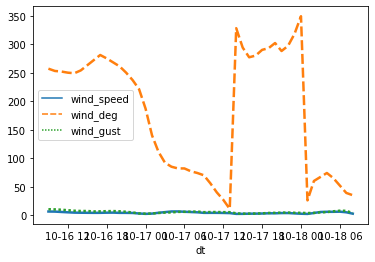

In [22]:
sns.lineplot(data=hourly_forecasts, palette="tab10", linewidth=2.5)
plt.show()